IA & Data science (LU3IN0226) -- 2024-2025
--------
*&copy; Equipe pédagogique: Christophe Marsala, Olivier Schwander, Jean-Noël Vittaut.*


# TD-TME10: méthodes d'ensembles

L'objectif de ce notebook est d'implémenter des méthodes d'ensembles et de les évaluer. Dans un premier temps, on se focalisera sur l'algorithme de bagging appliqué aux arbres de décision, puis on passera au random forests.

Dans un premier temps, on ne considére que le cas où les attributs sont tous numériques.

<font color="RED" size="+1">**[Q]**</font> **Indiquer dans la boîte ci-dessous vos noms et prénoms :**

Yuxiang Zhang et Antoine Lecomte

<font color="RED" size="+1"><b>[Q]</b></font> **Renommer ce fichier ipython**

**Nom à donner au fichier à poster** : *tme-10-Nom1_Nom2.ipynb* 
- *Nom1* et *Nom2* : noms des membres du binôme
- ne pas compresser ou faire une archive: il faut rendre le fichier ipython tel quel, éventuellement, si vous avez d'autres fichiers vous les rendez séparément.

**Echancier pour la soumission de votre compte-rendu:**
- le compte-rendu d'une séance doit être remis obligatoirement <font color="RED">avant la séance suivante</font>.

**Le compte-rendu est soumis sur la page Moodle.**

In [6]:
# - - - - - - - - - - - - - - - - - -
# imports utiles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mtpl
%matplotlib inline  

import math
import time
import sys

# Les instructions suivantes sont utiles pour recharger automatiquement 
# le code modifié dans les librairies externes
%load_ext autoreload
%autoreload 2

# - - - - - - - - - - - - - - - - - -
# Information sur l'environnent utilisé ici:
print("Version python et des librairies:")
print("\tPython ",sys.version)
print("\tpandas: ",pd.__version__)
print("\tnumpy: ",np.__version__)
print("\tmatplotlib: ",mtpl.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Version python et des librairies:
	Python  3.11.2 (main, Nov 30 2024, 21:22:50) [GCC 12.2.0]
	pandas:  2.2.0
	numpy:  1.24.2
	matplotlib:  3.6.3


In [7]:
# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
sys.path.append('../')   # iads doit être dans le répertoire père du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as classif

# importation de utils
from iads import utils as ut

# importation de evaluation
from iads import evaluation as ev

# importation de Clustering
from iads import Clustering as clust


## Préparation : retour sur les arbres de décision

### Création d'un dataset pour tester les fonctions

Taille du dataset généré : (100, 2) exemples


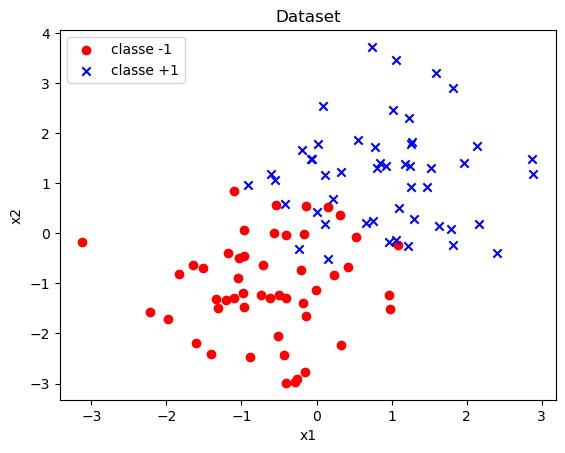

In [8]:
# REMARQUE: une fois les importations faites, les fonctions de utils sont utilisables
#  en mettant ut. devant leur nom:

# Exemple d'utilisation:
np.random.seed(42)   # on prend 42 comme graine

d_desc_gauss, d_label_gauss = ut.genere_dataset_gaussian(np.array([1,1]) ,np.array([[1,0],[0,1]]), \
                                                       np.array([-0.5,-1]), np.array([[1,0],[0,1]]), \
                                                       50)

print("Taille du dataset généré :", np.shape(d_desc_gauss), "exemples")

# Affichage :
ut.plot2DSet(d_desc_gauss,d_label_gauss)

### Frontière de séparation des classes 

<font color="RED" size="+1"><b>[Q]</b></font> En utilisant vos fonctions de construction des arbres numériques du TME 8, afficher la frontière de séparation des classes et l'arbre obtenu pour les données générées.

Accuracy (train): 1.0


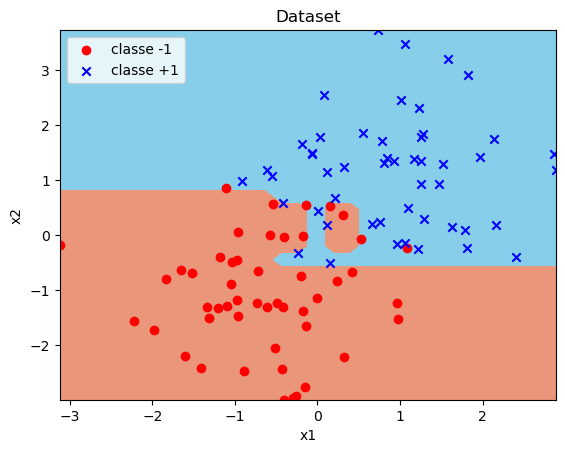

In [9]:
arbre = classif.ClassifierArbre(2, epsilon=0.05)

arbre.train(d_desc_gauss, d_label_gauss)

acc = arbre.accuracy(d_desc_gauss, d_label_gauss)
print("Accuracy (train):", acc)

ut.plot_frontiere(d_desc_gauss, d_label_gauss, arbre)
ut.plot2DSet(d_desc_gauss, d_label_gauss)

<font color="RED" size="+1"><b>[Q]</b></font> Afficher l'arbre construit.

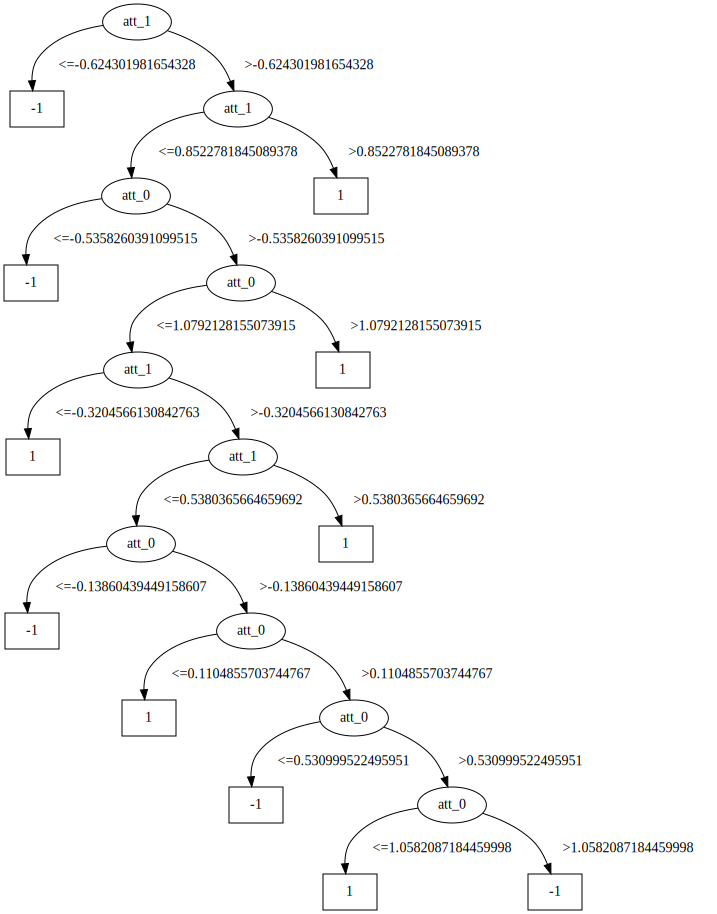

In [10]:
import graphviz
from graphviz import Digraph

dot = Digraph()
arbre.affiche(dot)
dot.render('arbre_decision', format='png', cleanup=False)
dot

<font color="RED" size="+1"><b>[Q]</b></font> Sur une feuille de papier, représenter la frontière de séparation des classes en la dessinant à la main et en utilisant l'arbre ci-dessus.

Même chose mais en utilisant un seuil d'entropie lors de la construction, ici égal à $0.8$ 


Accuracy (train): 0.85


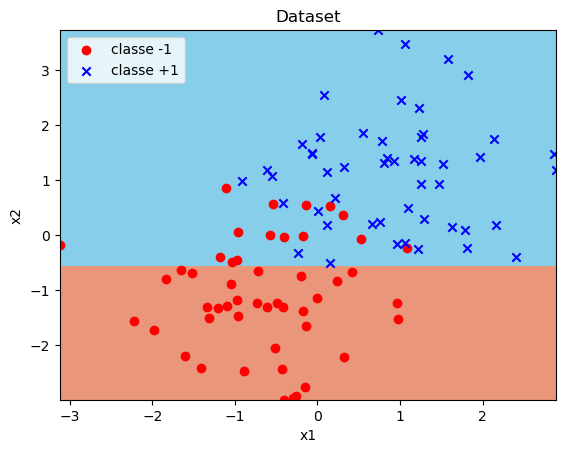

In [11]:
arbre = classif.ClassifierArbre(2, epsilon=0.8)

arbre.train(d_desc_gauss, d_label_gauss)

acc = arbre.accuracy(d_desc_gauss, d_label_gauss)
print("Accuracy (train):", acc)

ut.plot_frontiere(d_desc_gauss, d_label_gauss, arbre)
ut.plot2DSet(d_desc_gauss, d_label_gauss)

## Bagging d'arbres de décision

### Tirage aléatoire d'exemples

Le bootstrap s'effectue en tirant aléatoirement un échantillon de $m$ exemples à partir de la base d'apprentissage $X$. Cet échantillon sert ensuite à construire un classifieur.

Dans l'algorithme du bagging, ce processus est répété $B$ fois.

Afin de ne pas alourdir la place mémoire nécessaire pour réaliser un tel tirage, on ne travaille que sur les indices des exemples dans la base. Un **échantillon de $X$ est donc un vecteur d'entiers** qui représentent les indices des exemples choisis.


### Tirages aléatoires

Consulter la librairie Python random qui propose différentes fonctions utiles pour implémenter le tirage aléatoire du bootstrap.

Par exemple, la fonction <code>sample()</code> de la librairie <code>random</code> rend une sélection aléatoire dans une population donnée en réalisant un tirage sans remise.

Pour tester, exécuter plusieurs fois les instructions de la boîte suivante :

In [12]:
# ATTENTION : on utilise ici les fonctions de la librairie random pas numpy !
# Donc, on ne préfixe pas les fonction par np.

import random
random.seed(42)   # on prend 42 comme graine

L= [i for i in range(0,11)]             # construction de la liste des entiers de 0 à 10
print("La liste L de départ: ",L)
EchL_1 = random.sample(L,6)               # tirage de 6 éléments de L
print("Echantillon 1: ",EchL_1)
EchL_2 = random.sample(L,6)               # un autre tirage de 6 éléments de L
print("Echantillon 2: ",EchL_2)

La liste L de départ:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Echantillon 1:  [10, 1, 0, 4, 9, 6]
Echantillon 2:  [2, 1, 8, 9, 4, 3]


La fonction <code>choice()</code> permet de choisir aléatoirement un élément dans une liste:

In [13]:
random.seed(42)   # on prend 42 comme graine

L= [i for i in range(0,11)]             # construction de la liste des entiers de 0 à 10
print("La liste L de départ: ",L)
elt = random.choice(L)                  # choix d'un élémént
print("Element choisi: ",elt)

La liste L de départ:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Element choisi:  10


<font color="RED" size="+1">**[Q]**</font> Ecrire la fonction <code>tirage()</code> qui étant donné un vecteur d'entiers <i>VX</i> qui représente l'ensemble des indices des exemples d'une base d'apprentissage <i>X</i>, un entier $m$, et un booléen $r$, rend un vecteur de $m$ indices choisis aléatoirement dans <i>VX</i>. Si le booléen $r$ est vrai, le tirage s'effectue *avec remise*, sinon il s'effectue *sans remise*.

In [14]:
import random

def tirage(VX, m, avecRemise=False):
    """ VX: vecteur d'indices 
        m : nombre d'exemples à sélectionner (hypothèse: m <= len(VX))
        avecRemise: booléen, true si avec remise, ou faux sinon
    """
    if avecRemise:
        # avec remise
        return random.choices(VX, k=m)
    else:
        # sans remise
        return random.sample(VX, m)

Exemples :

In [15]:
random.seed(42)   # on prend 42 comme graine
L= [i for i in range(0,10)]    # construction de la liste des entiers de 0 à 100
Lrand = tirage(L,8,True)               # tirage avec remise
print("Tirage obtenu: ",Lrand)
# Choix de lignes quelconques de d_desc
d_desc_gauss[Lrand,:]

Tirage obtenu:  [6, 0, 2, 2, 7, 6, 8, 0]


array([[-0.25803773, -2.91328024],
       [-0.00328585, -1.1382643 ],
       [-0.73415337, -1.23413696],
       [-0.73415337, -1.23413696],
       [-2.22491783, -1.56228753],
       [-0.25803773, -2.91328024],
       [-1.51283112, -0.68575267],
       [-0.00328585, -1.1382643 ]])

Dans ce qui suit, pour faciliter les énoncés, on appelle <code>LabeledSet</code> un couple de 2 np.arrays $X$ pour les descriptions des exemples et $Y$ pour les labels correspondant à chaque exemple.

Par exemple, le <code>LabeledSet</code> pour les données générées précédemment est <code>(d_des_gauss,d_label_gauss)</code>.

<font color="RED" size="+1">**[Q]**</font> En utilisant la fonction précédente, écrire la fonction <code>echantillonLS()</code> qui, étant donné un <code>LabeledSet</code> $LS$, un nombre entier $m$, et un booléen $r$ (avec ou sans remise) rend le <code>LabeledSet</code> échantillon de $LS$ de taille $m$. 

*Remarque*: on peut faire l'hypothèse que $m$ est inférieur ou égal au nombre de lignes de $LS$. 


In [16]:
# ############################################## A COMPLETER 
def echantillonLS(LS,m,avecRemise):
    """ LS: LabeledSet (couple de np.arrays)
        m : entier donnant la taille de l'échantillon voulu (hypothèse: m <= len(LS))
        avecRemise: booléen pour le mode de tirage
    """
    (desc, labels) = LS
    
    indices = tirage(list(range(len(desc))), m, avecRemise)

    echantillon_desc = desc[indices, :]
    echantillon_labels = labels[indices]

    return echantillon_desc, echantillon_labels

In [17]:
echantillonLS((d_desc_gauss,d_label_gauss),10,True)

(array([[-1.3084936 , -1.50175704],
        [-0.73415337, -1.23413696],
        [-0.61564828, -1.3011037 ],
        [-0.41537074,  0.57935468],
        [-0.73415337, -1.23413696],
        [-1.82818605, -0.80313876],
        [ 1.09965137,  0.49652435],
        [ 1.25755039,  0.92555408],
        [-1.97852199, -1.71984421],
        [ 0.96528823, -0.16867804]]),
 array([-1, -1, -1,  1, -1, -1,  1,  1, -1,  1]))

<font color="RED" size="+1">**[Q]**</font> Ecrire la classe <code>ClassifierBaggingTree</code>, dérivée de la classe <code>Classifier</code>, qui permet d'implémenter un bagging d'arbres de décision (numériques). Les spécifications de cette classe sont :
- la création de l'ensemble nécessite les paramètres suivants :
    - la dimension des données (comme pour les classifieurs précédents) 
    - le nombre $B$ d'arbres à construire, 
    - le pourcentage d'exemples de la base d'apprentissage utilisés pour constituer un échantillon, 
    - un booléen qui précise si un échantillon est tiré avec ou sans remise
    - et la valeur de seuil d'entropie pour arrêter la construction de chaque arbre, 
- l'apprentissage (méthode <code>train()</code>) construit autant d'arbres que précisé à la création. Chaque arbre est construit à partir d'un échantillon de la base d'apprentissage (donnée sous forme d'un <code>LabeledSet</code>) donnée en argument. Les arbres construits sont stockés dans un ensemble Python.
- le score de classification <code>score()</code> est une valeur de $[-1,1]$ qui est calculé sur le modèle du score des $k$ plus proches voisins, il est basé sur le pourcentage de classifieurs qui ont donné la classe $+1$ pour l'exemple à classer. 
- la prédiction (méthode <code>predict()</code>) classe un exemple par vote de tous les arbres de la forêt. Si la somme des votes est positive ou nulle, la classe rendue est +1, sinon, la classe rendue est -1. Cette prédiction peut aussi être déterminée par le score: si celui-ci est supérieur ou éval à $0$ alors la classe prédite sera +1, sinon elle sera -1.


In [18]:
class ClassifierBaggingTree(classif.Classifier):
    """ Classifier utilisant le bagging d'arbres de décision """
    
    def __init__(self, input_dimension, B, pourcentage_echantillon, epsilon, avecRemise):
        """ Initialisation avec epsilon avant avecRemise """
        super().__init__(input_dimension)
        self.B = B
        self.pourcentage_echantillon = pourcentage_echantillon
        self.epsilon = epsilon
        self.avecRemise = avecRemise
        self.arbres = []
    
    def train(self, desc_set, label_set):
        """ Entraînement du modèle en construisant B arbres de décision """
        n = len(desc_set)
        m = int(n * self.pourcentage_echantillon)
    
        for _ in range(self.B):
            # Créer un échantillon bootstrap
            echantillon_desc, echantillon_labels = echantillonLS((desc_set, label_set), m, self.avecRemise)
            
            # Vérifier que l'échantillon contient au moins 2 classes
            if len(np.unique(echantillon_labels)) < 2:
                print("Avertissement: Échantillon ne contient qu'une seule classe")
                continue
                
            # Créer et entraîner un arbre avec epsilon
            arbre = classif.ClassifierArbre(self.dimension, self.epsilon, [])
            arbre.train(echantillon_desc, echantillon_labels)
            
            if arbre.racine is not None:
                self.arbres.append(arbre)
            else:
                print("Avertissement: Échec construction arbre - données peut-être non séparables")

    def predict(self, x):
        """ Prédiction basée sur le vote des arbres """
        votes = [arbre.predict(x) for arbre in self.arbres if arbre.racine is not None]
        if not votes:
            raise ValueError("Aucun arbre n'a été correctement entraîné.")
        return 1 if sum(votes) >= 0 else -1
    
    def score(self, x):
        """ Calcul du score de classification (valeur réelle) """
        votes = np.array([arbre.predict(x) for arbre in self.arbres])
        score = np.sum(votes)
        return score / self.B

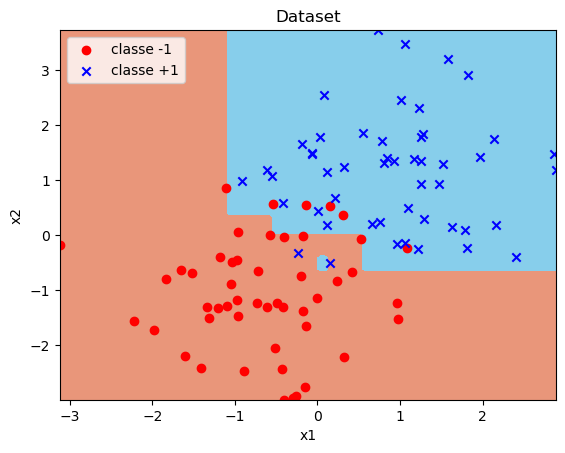


accuracy totale: 0.95


In [19]:
# Exemple d'utilisation

random.seed(42)   # on prend 42 comme graine

# Forêt de 5 arbres:
foret_1 = ClassifierBaggingTree(2,5,0.8,0.0,True)
foret_1.train(d_desc_gauss,d_label_gauss)

# Affichage de la frontière de séparation des classes
ut.plot_frontiere(d_desc_gauss,d_label_gauss,foret_1,step=100)
ut.plot2DSet(d_desc_gauss,d_label_gauss)

print("\naccuracy totale:",foret_1.accuracy(d_desc_gauss,d_label_gauss))

### Expérimentations

<font color="RED" size="+1">**[Q]**</font> Expérimenter l'algorithme précédent de la façon suivante :
- générer un dataset de train $Data$ contenant 1000 exemples ;
- générer une base de test $T$ contenant 200 exemples ;
- réaliser un apprentissage par bagging avec $Data$ et évaluer le taux de prédiction du modèle obtenu sur $T$ ;

**Remarque**: réinitialiser la graine aléatoire avant de construire une forêt.

In [23]:
def gen_arti(centerx=0, centery=0, sigma=0.1, nbex=1000, data_type=0, epsilon=0.1):
    """ Génère des données artificielles selon 4 types différents
        centerx, centery: centre des gaussiennes
        sigma: écart type
        nbex: nombre d'exemples
        data_type: 0: gaussiennes opposées, 1: cercle, 2: XOR, 3: spirales
        epsilon: bruit dans les données
    """
    if data_type == 0:
        # Deux gaussiennes opposées
        x_pos = np.random.normal(centerx, sigma, (nbex//2, 2))
        x_neg = np.random.normal(-centerx, sigma, (nbex//2, 2))
        x = np.concatenate((x_pos, x_neg))
        y = np.array([1]*len(x_pos) + [-1]*len(x_neg))
    elif data_type == 1:
        # Données en cercle
        theta = np.random.uniform(0, 2*np.pi, nbex)
        r = sigma * np.random.randn(nbex) + 1
        x = np.column_stack((r*np.cos(theta), r*np.sin(theta)))
        y = np.where(theta < np.pi, 1, -1)
    else:
        raise ValueError("Type de données non implémenté")
    
    # Ajout d'un peu de bruit
    x += epsilon * np.random.randn(*x.shape)
    return x, y

# ==================== PARTIE 1: Génération des données ====================
random.seed(42)  # Pour reproductibilité
Data, y_Data = gen_arti(centerx=1, centery=1, sigma=0.1, nbex=1000, data_type=0, epsilon=0.1)
Test, y_Test = gen_arti(centerx=1, centery=1, sigma=0.1, nbex=200, data_type=0, epsilon=0.1)

# ==================== PARTIE 2: Expérimentation Bagging ====================
# Paramètres
B_values = [5, 10, 20, 50]  # Tailles de forêt à tester
epsilon = 0.1                # Seuil d'entropie
pourcentage = 0.8            # Pourcentage d'échantillonnage
accuracy_list = []

# Boucle d'expérimentation
for B in B_values:
    random.seed(42)  # Réinitialisation pour chaque forêt
    
    # Création et entraînement
    foret = cl.ClassifierBaggingTree(2, B, pourcentage, epsilon, True)
    foret.train(Data, y_Data)
    
    # Évaluation
    acc = foret.accuracy(Test, y_Test)
    accuracy_list.append(acc)
    print(f"Forêt B={B}: Accuracy = {acc:.3f}")

# ==================== PARTIE 3: Visualisation ====================
# 1. Courbe d'accuracy
plt.figure(figsize=(10,6))
plt.plot(B_values, accuracy_list, 'o-', markersize=8)
plt.xlabel("Nombre d'arbres (B)", fontsize=12)
plt.ylabel("Accuracy sur le test set", fontsize=12)
plt.title("Performance du bagging en fonction de la taille de la forêt", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(B_values)
plt.show()

# 2. Visualisation des frontières pour B=20 (valeur médiane)
random.seed(42)
foret = cl.ClassifierBaggingTree(2, 20, 0.8, 0.1, True)
foret.train(Data, y_Data)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
ut.plot_frontiere(Data, y_Data, foret, step=50)
ut.plot2DSet(Data, y_Data)
plt.title("Frontière de décision (Train set)", fontsize=12)

plt.subplot(1,2,2)
ut.plot_frontiere(Test, y_Test, foret, step=50)
ut.plot2DSet(Test, y_Test)
plt.title("Frontière de décision (Test set)", fontsize=12)
plt.tight_layout()
plt.show()

# ==================== PARTIE 4: Comparaisons ====================
# Comparaison avec un arbre seul
arbre = cl.ClassifierArbre(2, 0.1, [])
arbre.train(Data, y_Data)
print(f"\nComparaison:")
print(f"- Arbre seul: Accuracy = {arbre.accuracy(Test, y_Test):.3f}")
print(f"- Forêt (B=20): Accuracy = {accuracy_list[2]:.3f}")

# Test de stabilité (5 runs avec B=10)
print("\nTest de stabilité (B=10):")
for i in range(5):
    random.seed(i)  # Graine différente à chaque run
    foret = cl.ClassifierBaggingTree(2, 10, 0.8, 0.1, True)
    foret.train(Data, y_Data)
    print(f"Run {i+1}: Accuracy = {foret.accuracy(Test, y_Test):.3f}")

NameError: name 'cl' is not defined

<font color="RED" size="+1">**[Q]**</font> En utilisant le résultat précédent, construire la courbe donnant la variation du **taux d'erreur** en fonction du nombre d'arbres dans la forêt.


## Version multiclasses

<font color="RED" size="+1">**[Q]**</font> Réaliser une version multiclasses de cet algorithme en utilisant le ̀`ClassifierMultiOAA` du TME 4 (qui doit peut être être adapté) et l'expérimenter sur les données des Iris de Fischer du TME 7.



## (optionnel) Evaluation par la méthode "Out Of Bags"

<font color="RED" size="+1">**[Q]**</font> Sur les mêmes données, réaliser une évaluation par la méthode "Out Of Bags" vue dans le cours 11. Construire la courbe donnant le taux de prédiction OOB en fonction de la taille de la forêt d'arbres.

Pour cela, écrire la classe <code>ClassifierBaggingTreeOOB</code> qui étend la classe d'un classifieur bagging pour prendre en compte la spécificité de l'approche OOB.
Ainsi, à partir de $\mathcal{X}$, l'ensemble des données d'apprentissage, chaque arbre $A_i$ de la forêt est associé à 2 sous-ensembles de $\mathcal{X}$: 
- $\mathcal{X}_i$: l'échantillon bootstrap qui sert à construire l'arbre $A_i$
- $\mathcal{T}_i$: l'ensemble des exemples OOB associés à l'arbre $A_i$

Le calcul du taux de bonne classification s'effectuera comme suit:
- soit $t_i$ le taux de bonne classification de $A_i$ pour l'ensemble OOB $\mathcal{T}_i$
- le taux de global de bonne classification de la forêt d'arbres $A_1$,..., $A_B$ est donné par $\frac{1}{B}\sum_{i=1}^{B} t_i$


# Expérimentations

Réaliser des expérimentations avec l'algorithme de bagging d'arbres sur différents jeux de données vus lors des séances précédentes.

Comparer cet algorithme avec les autres algorithmes d'apprentissage que vous avez implémenter.
